# Mutual Information
Plot estimated mutual information saved in a directory and compare them among different models.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style("ticks")
sns.set_context("paper", 1.5, {"lines.linewidth": 2})

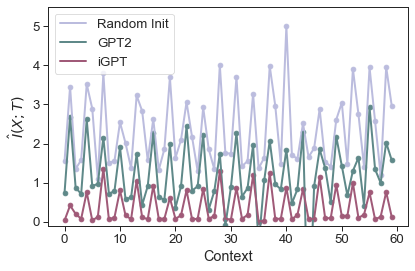

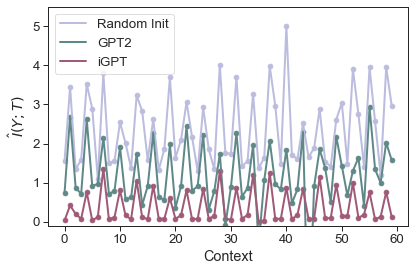

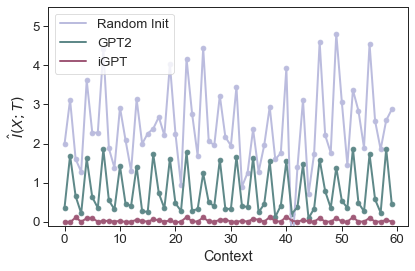

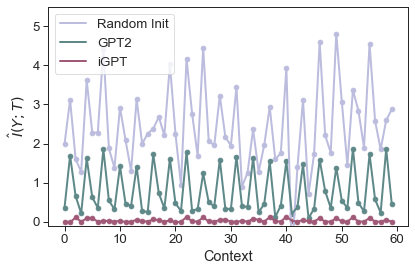

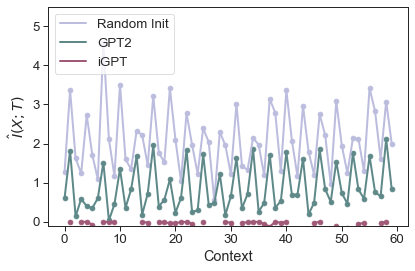

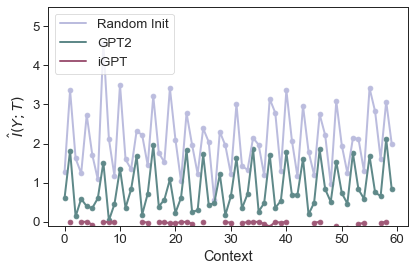

In [6]:
epoch = 40
seed = 666
batch_size = 100
env_name = 'hopper'
dataset_name = 'medium'

model_names = ['dt', 'gpt2', 'igpt']
block_positions = ['shallow', 'middle', 'deep']

layer_name_map = {'shallow': '0.mlp.dropout', 'middle': '6.mlp.dropout', 'deep': '11.mlp.dropout'}
layer_name_igpt_map = {'shallow': '0.mlp.dropout', 'middle': '12.mlp.dropout', 'deep': '23.mlp.dropout'}
colors = {'dt': (0.733, 0.737, 0.870), 'gpt2': (0.372, 0.537, 0.537), 'igpt': (0.627, 0.352, 0.470)}
labels = {'dt': 'Random Init', 'gpt2': 'GPT2', 'igpt': 'iGPT'}

path_to_saved_mi = 'path_to_saved_mi'
path_to_save_figure = 'path_to_save_figure'

# Create different comparison plots for shallow/middle/deep.
for block_position in block_positions:
    mutual_information = {
        'x': {},
        'y': {}
    }
    for model_name in model_names:
        if model_name == 'igpt':
            layer_name = layer_name_igpt_map[block_position]
        else:
            layer_name = layer_name_map[block_position]
        mi_dict = np.load(f'{path_to_saved_mi}/mi_xy_{layer_name}_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}_{batch_size}.npy', allow_pickle=True).item()
        '''
        e.g.
        mi_dict = {
            '0.mlp.dropout': [
                x_mi_list,  # list of I(X_t; T) (t = 1, ..., K - 1)
                y_mi_list   # list of I(Y; T_t) (t = 1, ..., K - 1)
            ],
            ...
        }
        '''

        x_mi_list = mi_dict[f'{layer_name}'][0]
        y_mi_list = mi_dict[f'{layer_name}'][1]

        mutual_information['x'][model_name] = x_mi_list
        mutual_information['y'][model_name] = x_mi_list
    
    '''
    mutual_information = {
        'x': {
            'gpt2': x_mi_list (of gpt2        & shallow/middle/deep),
            'igpt': x_mi_list (of igpt        & shallow/middle/deep),
            'dt':   x_mi_list (of rand. init. & shallow/middle/deep)
        },
        'y': {
            ...
        }
    }
    '''

    for x_or_y, mi_dict in mutual_information.items():
        for model_name in model_names:
            plt.plot(mi_dict[model_name], color=colors[model_name], label=labels[model_name])
            plt.scatter(np.arange(len(mi_dict[model_name])), mi_dict[model_name], color=colors[model_name])

        if x_or_y == 'x':
            plt.ylabel(r'$\hat{I}(X; T)$')
        else:
            plt.ylabel(r'$\hat{I}(Y; T)$')
        plt.xlabel('Context')
        plt.ylim(-0.1, 5.5)
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'{path_to_save_figure}/mi_{x_or_y}_{layer_name}_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}_{batch_size}.pdf')
        plt.show()

In [7]:
def smooth_sequence(sequence):
    sequence_normalized = []
    for i in range(len(sequence) // 2):
        sequence_normalized.append(sequence[i * 2: (i + 1) * 2].mean())
    sequence = np.array(sequence_normalized)
    return sequence

/Users/shiro/miniforge3/envs/wikirl-gym/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1741: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe', where=where)


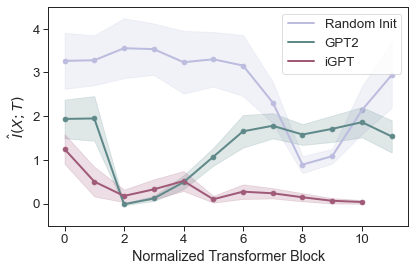

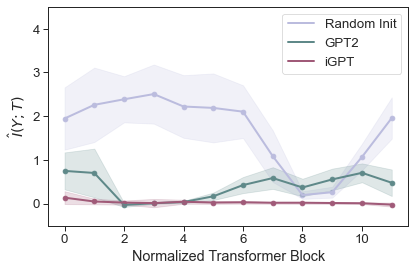

In [21]:
epoch = 40
env_name = 'hopper'
dataset_name = 'medium'
batch_size = 100

model_names = ['dt', 'gpt2', 'igpt']
colors = {'dt': (0.733, 0.737, 0.870), 'gpt2': (0.372, 0.537, 0.537), 'igpt': (0.627, 0.352, 0.470)}
labels = {'dt': 'Random Init', 'gpt2': 'GPT2', 'igpt': 'iGPT'}

mutual_information = {
    'state': {},
    'action': {}
}

for model_name in model_names:
    mi_dict = np.load(f'{path_to_saved_mi}/mi_{epoch}_{model_name}_{env_name}_{dataset_name}_{seed}_{batch_size}.npy', allow_pickle=True).item()

    mutual_information['state'][model_name] = [mi_lists[0] for mi_lists in mi_dict.values()]
    mutual_information['action'][model_name] = [mi_lists[1] for mi_lists in mi_dict.values()]

for state_or_action, mi_dict_model in mutual_information.items():
    for model_name, mi_list in mi_dict_model.items():
        mi_mean = np.array([np.nanmean(mi_all_token_pos) for mi_all_token_pos in mi_list])
        mi_std = np.array([np.nanstd(mi_all_token_pos) for mi_all_token_pos in mi_list])
        if model_name == 'igpt':
            mi_mean = smooth_sequence(mi_mean)
            mi_std = smooth_sequence(mi_std)

        plt.fill_between(np.arange(len(mi_mean)), mi_mean - mi_std, mi_mean + mi_std, alpha=0.2, color=colors[model_name])
        plt.plot(mi_mean, color=colors[model_name], label=labels[model_name])
        plt.scatter(np.arange(len(mi_mean)), mi_mean, color=colors[model_name])

    if state_or_action == 'state':
        plt.ylabel(r'$\hat{I}(X; T)$')
    else:
        plt.ylabel(r'$\hat{I}(Y; T)$')
    plt.xlabel('Normalized Transformer Block')
    plt.ylim(-0.5, 4.5)
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.savefig(f'{path_to_save_figure}/mi_{state_or_action}_{epoch}_gpt2_igpt_dt_{env_name}_{dataset_name}_{seed}_{batch_size}.pdf')
    plt.show()